# 模拟合约对于Uni的对冲作用

In [1]:
import pandas as pd
import numpy as np
import math
import plotly.graph_objects as go

import plotly.io as pio
pio.renderers.default = 'notebook'

In [2]:
# 模拟币本位合约盈亏

# 生成价格序列
def gen_price_series(start_price, end_price, n):
    price_series = [start_price]
    interval = (end_price - start_price) / n
    for i in range(n):
        price_series.append(price_series[i] + interval)
    return price_series

# 计算盈亏
def calc_bi_pnl(open, close,direction,contract_value):
    return (1/open - 1/close) * direction * contract_value
def calc_u_pnl(open, close,direction,contract_value):
    return (close - open)/open * direction * contract_value
    

In [3]:
start_price = 20000
end_price = 40000
mid_price = (start_price + end_price) / 2

In [4]:
price = gen_price_series(start_price, end_price, 500)
price = pd.DataFrame(price, columns=['price'])
price['bi_pnl'] = price.apply(lambda x: calc_bi_pnl(mid_price, x['price'], 1, mid_price * 0.5), axis=1)
price['u_pnl'] = price.apply(lambda x: calc_u_pnl(mid_price, x['price'], -1, mid_price * 0.5), axis=1)

In [5]:
# 模仿uniswap做市的币的变动

def get_deltax(p0,p1,liq):
    a0 = liq * (1/math.sqrt(p1) - 1/math.sqrt(p0))
    return a0

def get_deltay(p0,p1,liq):
    a0 = liq * (math.sqrt(p1) - math.sqrt(p0))
    return a0

price['a0'] = price.apply(lambda x: get_deltax(mid_price, x['price'], math.sqrt(30000 * 1)), axis=1)
price['a1'] = price.apply(lambda x: get_deltay(mid_price, x['price'], math.sqrt(30000 * 1)), axis=1)
    

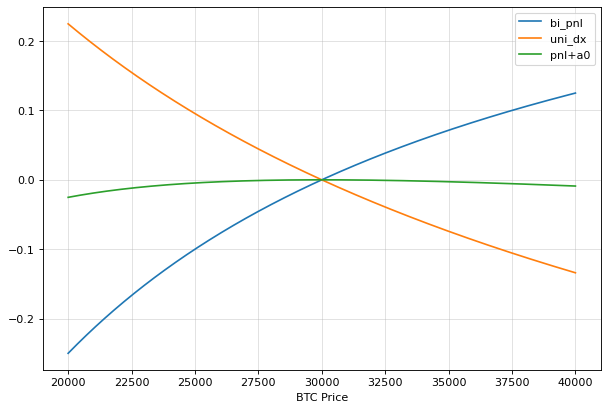

In [6]:
# 画图，横轴为price，纵轴为pnl
import matplotlib.pyplot as plt
# 设置尺寸
plt.figure(figsize=(9, 6), dpi=80)
plt.plot(price['price'], price['bi_pnl'])
plt.plot(price['price'], price['a0'])
plt.plot(price['price'], price['bi_pnl'] + price['a0'])

# 图例
plt.legend(['bi_pnl', 'uni_dx', 'pnl+a0'])
# 网格
plt.xlabel('BTC Price')
plt.grid(alpha=0.4)
plt.show()

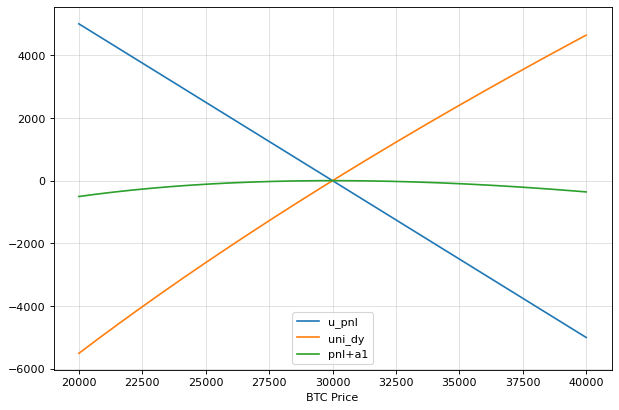

In [7]:
# 画图，横轴为price，纵轴为u_pnl,a1
# 设置尺寸
plt.figure(figsize=(9, 6), dpi=80)
plt.plot(price['price'], price['u_pnl'])
plt.plot(price['price'], price['a1'])
plt.plot(price['price'], price['u_pnl'] + price['a1'])

# 图例
plt.legend(['u_pnl', 'uni_dy', 'pnl+a1'])
# 网格
plt.xlabel('BTC Price')

plt.grid(alpha=0.4)
plt.show()

In [20]:
price['error'] = (1 / price['price'] - 1 / mid_price) * math.sqrt(25 * 50000) + (1/mid_price - 1/price['price']) * 50000
price['errorUsdt'] = price['error'] * price['price']
price

,price,bi_pnl,u_pnl,a0,a1,error,errorUsdt
0,20000.0,-0.250000,5000.0,0.224745,-5505.102572,-0.814699,-16293.988670
1,20040.0,-0.248503,4980.0,0.223522,-5480.619910,-0.809821,-16228.812716
2,20080.0,-0.247012,4960.0,0.222303,-5456.161669,-0.804962,-16163.636761
3,20120.0,-0.245527,4940.0,0.221087,-5431.727777,-0.800122,-16098.460806
4,20160.0,-0.244048,4920.0,0.219875,-5407.318162,-0.795302,-16033.284852
...,...,...,...,...,...,...,...
496,39840.0,0.123494,-4920.0,-0.132237,4571.664698,0.402442,16033.284852
497,39880.0,0.123872,-4940.0,-0.132673,4589.015597,0.403673,16098.460806
498,39920.0,0.124248,-4960.0,-0.133107,4606.357797,0.404901,16163.636761
499,39960.0,0.124625,-4980.0,-0.133541,4623.691311,0.406126,16228.812716


In [81]:
import math
p2 = 2000
p0 = p2 * 0.95
p1 = p2 * 1.05

q96 = 1 
a0 = 25
a1 = 50000

sqrtp0 = (math.sqrt(p0)* q96)
sqrtp1 = (math.sqrt(p1)* q96)
sqrtp2 = (math.sqrt(p2)* q96)

liq0 = a0 * (sqrtp2 * sqrtp1) / q96 / (sqrtp1 - sqrtp2)
liq1 = a1 * q96 / (sqrtp2 - sqrtp0)
liq = min(liq0, liq1)
print("liq is: ", liq)

rx = liq * q96 * (sqrtp1 - sqrtp2) / (sqrtp2 * sqrtp1)
ry = liq * (sqrtp2 - sqrtp0) / q96
print("rx is: ", rx)
print("ry is :", ry)

liq is:  44155.17449270128
rx is:  23.794815160510563
ry is : 50000.0


In [82]:
import numpy as np
from scipy.optimize import minimize

# 定义函数f(p1, a)
def f(p1, a):
    # 这里定义函数f的具体表达式
    p0 = 2000
    return (1/p1**0.5 - 1/p0**0.5)*liq + (1/p0 - 1/p1) * a
# 定义方差函数

def f1(p1,a):
    p0 = 2000
    return (p1 ** 0.5 - p0 ** 0.5) * liq + (p1 - p0) * a/p1


def get_p1_values():
    return np.linspace(p0, p1, 100)

def variance(b):
    # 计算f(p1, b)的方差
    p1_values = get_p1_values()
    var = np.var([f(p1, b) for p1 in p1_values])
    return var

def variance1(b):
    # 计算f(p1, b)的方差
    p1_values = get_p1_values()
    var = np.var([f1(p1, b) for p1 in p1_values])
    return var
# 设置初始猜测值
initial_guess = 243

# 最小化方差函数
result = minimize(variance, initial_guess)
result1 = minimize(variance1, initial_guess)
# 输出最小化方差的最优解
optimal_b = result.x[0]
print("Optimal value of b:", optimal_b)

#
optimal_b1 = result1.x[0]
print("Optimal value of b1:", optimal_b1)
# 杠杆倍数
print("Optimal leverage:", optimal_b / 100000)


Optimal value of b: 969506.3959811984
Optimal value of b1: -985516.9901217188
Optimal leverage: 9.695063959811984


In [83]:
# 计算Pnl
pnl = [f(p1,optimal_b) for p1 in get_p1_values()]
pnl1 = [f1(p1,optimal_b1) for p1 in get_p1_values()]

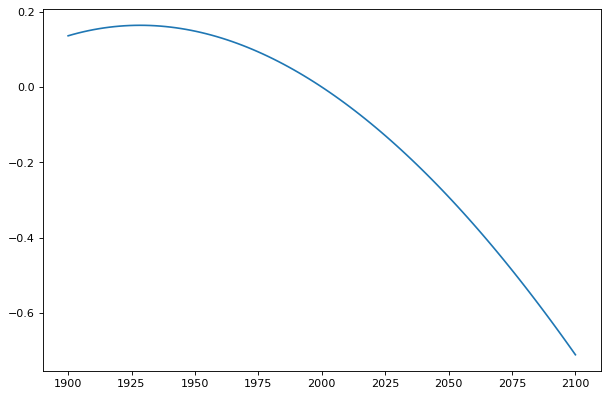

In [84]:
# 画出pnl和p1的关系
import matplotlib.pyplot as plt
# 设置尺寸
plt.figure(figsize=(9, 6), dpi=80)
plt.plot(get_p1_values(), pnl)

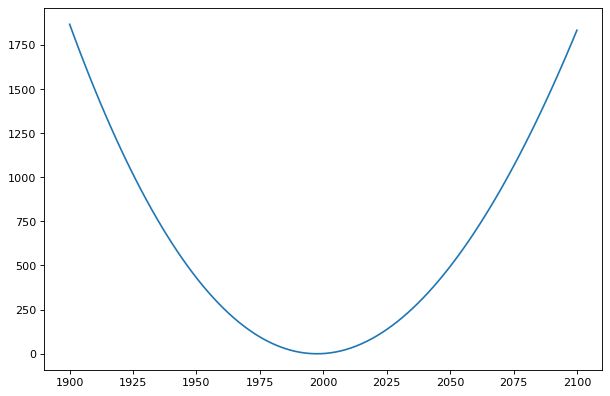

In [85]:
# 画出pnl1和p1的关系
plt.figure(figsize=(9, 6), dpi=80)
plt.plot(get_p1_values(), pnl1)

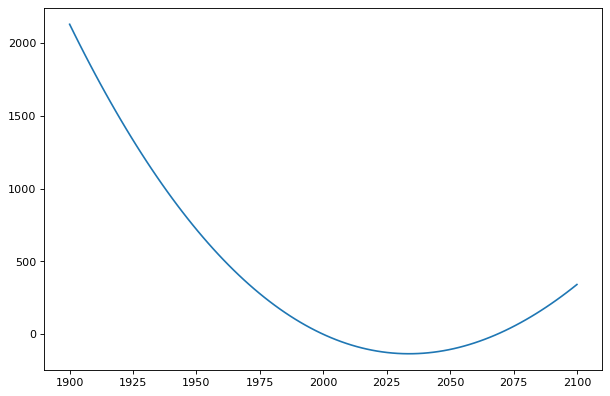

In [86]:
all_pnl = np.array(pnl) * get_p1_values() + np.array(pnl1)
plt.figure(figsize=(9, 6), dpi=80)
plt.plot(get_p1_values(), all_pnl)